# Load and preprocess data

Here I load, and do some minimal preprocessing, which I arrived at in the EDA notebook.

In [1]:
import os, time, gc
from collections import deque
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

%matplotlib inline

In [2]:
def load_sales(parse_date = True):
    data_fol = 'data'
    sales = pd.read_csv(os.path.join(data_fol, 'sales_train.csv'))
    if parse_date:
        date_col = pd.to_datetime(sales.date, format='%d.%m.%Y')
        sales.date = date_col
        sales['Month'] = sales.date.dt.to_period('M')
    return sales

def aggregate_monthly(sales_df):
    assert 'Month' in sales_df.columns, 'Month column not found'
    return (sales_df
            .groupby(['Month', 'shop_id', 'item_id'])
            .agg({'item_cnt_day': np.sum, 'item_price': np.mean})
            .rename(columns={'item_cnt_day':'item_cnt_month'})
           )

In [3]:
def load_all():
    sales = load_sales()
    agg_sales = aggregate_monthly(sales)
    items = pd.read_csv('data/items.csv')
    categories = pd.read_csv('data/item_categories.csv')
    test_set = pd.read_csv('data/test.csv')
    return sales, agg_sales, items, categories, test_set

In [4]:
def create_submission_like_df():
    months = sorted(agg_sales.index.levels[0])
    submission_like_data  = {}
    for month in months:    
        month_data = agg_sales.loc[month]
        shops = set(month_data.index.get_level_values(0))
        item_ids = set(month_data.index.get_level_values(1))

        new_idx = pd.Index(product(shops, item_ids), name=month_data.index.name)
        submission_like_data[month] = month_data.reindex(new_idx).fillna({'item_cnt_month':0, 'item_price':-1})
        
    submission_like_df = pd.concat(submission_like_data)
    submission_like_df.index.names = agg_sales.index.names
    
    return submission_like_df

In [5]:
sales, agg_sales, items, categories, test_set = load_all()

In [6]:
agg_sales = agg_sales.drop(6066, level=2)

In [7]:
agg_sales.loc[agg_sales.item_price <= 0.1, 'item_price'] = np.nan
agg_sales['item_price'] = agg_sales.groupby(level=2).item_price.transform(lambda x: x.fillna(x.mean()))

In [8]:
cat_annotated_agg_sales = (pd.merge(agg_sales.reset_index(), items.drop('item_name', axis=1), on='item_id')
                           .set_index(['Month', 'shop_id', 'item_id'])
                           .sort_index(level=[0,1,2])
                          )

In [9]:
submission_like_df = create_submission_like_df()

In [10]:
months = sorted(agg_sales.index.levels[0])

<hr>
<hr>
<hr>

# Simple Linear Model

I create a simple linear model, using only some aggregated and lagged features. While it was originally meant for ensembling with final model, it ended up not being helpful there, so instead I use this models predictions as a feature for the more powerful model (below).

In [11]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import r2_score

## Feature Generation

Here I create the features I will use, along with their lagged values.

In [12]:
ext_agg_sales  = agg_sales.copy().drop('item_price', axis=1)
ext_agg_sales['total_shop_cnt_month'] = agg_sales.groupby(level=[0,1]).item_cnt_month.transform('sum')
ext_agg_sales['total_item_cnt_month'] = agg_sales.groupby(level=[0,2]).item_cnt_month.transform('sum')

In [13]:
ext_agg_sales.head()

item_cnt_month  total_shop_cnt_month  \
Month   shop_id item_id                                         
2013-01 0       32                  6.0                5578.0   
                33                  3.0                5578.0   
                35                  1.0                5578.0   
                43                  1.0                5578.0   
                51                  2.0                5578.0   

                         total_item_cnt_month  
Month   shop_id item_id                        
2013-01 0       32                      299.0  
                33                       61.0  
                35                       78.0  
                43                        2.0  
                51                       13.0

In [14]:
shops = sorted(ext_agg_sales.index.levels[1])
idx_cols = ['Month', 'item_id']
cols_to_lag = ['item_cnt_month', 'total_shop_cnt_month', 'total_item_cnt_month']

In [15]:
to_previous_month_map = dict(zip(months[1:], months))
obj_month_map = dict(zip(months, months[1:]+[pd.Period('2015-11')]))

I will actually fit one model per shop, and then put together.

In [16]:
def get_single_shop_data(shopnum):
    lag_month_map = dict(zip(months, months[1:]))
    forward_month_map = dict(zip(months[1:], months))

    def rename_col(col, s):
        return f'{col}_lag_{s}'

    single_shop = ext_agg_sales.loc[pd.IndexSlice[:,shopnum,:],:].reset_index(level=1, drop=True).reset_index()

    shifted = [single_shop.copy().dropna().set_index(idx_cols)]
    for shift in [1,2,3,4,5,8,11]:
        single_shop_shift = single_shop.copy()
        month = single_shop.Month
        for s in range(1,shift+1):
            month = month.map(lag_month_map)
        single_shop_shift.Month = month
        single_shop_shift.columns = [rename_col(col, shift) if col in cols_to_lag else col for col in single_shop_shift.columns ]
        shifted.append(single_shop_shift.dropna().set_index(idx_cols))

    all_data_single_shop = pd.concat(shifted, axis=1).fillna(0)
    single_shop_target = single_shop.copy()
    single_shop_target.Month = single_shop_target.Month.map(forward_month_map)
    all_data_single_shop['target'] = single_shop_target.dropna().set_index(idx_cols).item_cnt_month
    all_data_single_shop = all_data_single_shop.loc[months[12:]] # remove first 12 months with incomplete features
    
    return all_data_single_shop

## Prediction

In [17]:
def get_single_shop_predictions(mod, all_data_single_shop):
    out_sample_preds = []
    for (train_month_thresh, test_month) in zip(months[12:-1], months[13:]):
        X_train, Y_train = (all_data_single_shop.loc[:train_month_thresh].drop('target', axis=1), all_data_single_shop.loc[:train_month_thresh, 'target'])
        X_test, Y_test = (all_data_single_shop.loc[[test_month]].drop('target', axis=1), all_data_single_shop.loc[[test_month], 'target'])
        if (len(X_test) == 0) or (len(X_train) == 0):
            continue
        fitted_model = mod.fit(X_train, Y_train.fillna(0))
        ytest_pred = fitted_model.predict(X_test)
        out_sample_preds.append(pd.Series(ytest_pred, index=X_test.index))
        #print(f'Test month: {test_month}, Test R-squared is: {r2_score(Y_test, ytest_pred)}' )
    if out_sample_preds:
        return pd.concat(out_sample_preds)
    else:
        return None


In [18]:
%%time
# mod = LinearRegression()
mod = ElasticNet(alpha=2, l1_ratio=0.25, max_iter=100000)
shops_pred = {}
for shop in shops:
    start = time.time()
    single_shop_data = get_single_shop_data(shop)
    preds =  get_single_shop_predictions(mod, single_shop_data)
    if preds is not None:
        shops_pred[shop] = preds
    # print(time.time()-start)
    

C:\Users\luisr\Anaconda3\envs\xgb\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\luisr\Anaconda3\envs\xgb\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\luisr\Anaconda3\envs\xgb\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\luisr\Anaconda3\envs\xgb\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\lui

Wall time: 5min 27s


In [19]:
shops_pred_df = pd.concat(shops_pred, names=['shop_id']).swaplevel(0,1).rename('Pred1')

In [20]:
shops_pred_df.head()

Month    shop_id  item_id
2014-02  2        30         0.645554
                  31         0.049581
                  32         0.283372
                  33         0.754955
                  97         0.137998
Name: Pred1, dtype: float64

## Conform to submission like df

For the purposes of consistent validation, I conform the prediction above to the submission like df already created. That df is the one that mimics the test set better.

In [21]:
temp_sub = submission_like_df.item_cnt_month.reset_index()
temp_sub.Month = temp_sub.Month.map(to_previous_month_map)
temp_sub = temp_sub[temp_sub.Month >= min(shops_pred_df.index.levels[0])].set_index(['Month', 'shop_id', 'item_id'])

In [22]:
model1_oos_predictions = shops_pred_df.reindex(temp_sub.index).fillna(0)

In [23]:
model1_oos_predictions.head()

Month    shop_id  item_id
2014-02  2        27         0.000000
                  28         0.000000
                  29         0.000000
                  30         0.645554
                  31         0.049581
Name: Pred1, dtype: float64

Include final prediction

In [24]:
final_pred = shops_pred_df.loc[months[-1]].reindex(test_set.set_index(['shop_id','item_id']).index).fillna(0)
final_pred = pd.concat([final_pred], keys=[months[-1]], names=['Month'])

Realign months so that it represents prediction month and not data month

In [25]:
model1_oos_predictions = pd.concat([model1_oos_predictions, final_pred]).reset_index()
model1_oos_predictions.Month = model1_oos_predictions.Month.map(obj_month_map)
model1_oos_predictions = model1_oos_predictions.set_index(['Month', 'shop_id', 'item_id']).sort_index()

In [26]:
model1_oos_predictions.head()

Pred1
Month   shop_id item_id          
2014-03 2       27       0.000000
                28       0.000000
                29       0.000000
                30       0.645554
                31       0.049581

In [ ]:
model1_oos_predictions.to_pickle('EN_model_predictions.p')

## Errors

In [28]:
from sklearn.metrics import mean_squared_error

In [29]:
def get_error(full_predictions_series, full_data):
    rmse = {}
    for month in sorted(full_predictions_series.index.levels[0])[:-1]:
        ypred = full_predictions_series.loc[month].sort_index()
        ytrue = full_data.loc[month].sort_index()
        rmse[month] = np.sqrt(mean_squared_error(ytrue, ypred))
    return pd.Series(rmse)

In [30]:
get_error(model1_oos_predictions.Pred1, submission_like_df.item_cnt_month)

2014-03    2.024727
2014-04    2.511645
2014-05    1.656804
2014-06    1.879623
2014-07    1.228892
2014-08    1.250089
2014-09    3.013957
2014-10    2.936116
2014-11    3.222223
2014-12    3.024958
2015-01    3.083645
2015-02    2.854308
2015-03    2.153976
2015-04    4.329503
2015-05    3.250949
2015-06    1.641582
2015-07    1.072869
2015-08    1.262157
2015-09    6.448914
2015-10    4.554570
Freq: M, dtype: float64

In [31]:
get_error(model1_oos_predictions.Pred1.clip(0,20), submission_like_df.item_cnt_month)

2014-03    3.035892
2014-04    3.119146
2014-05    2.407830
2014-06    2.600050
2014-07    2.266811
2014-08    2.427879
2014-09    3.692124
2014-10    3.698570
2014-11    4.064453
2014-12    4.876658
2015-01    4.155309
2015-02    1.642374
2015-03    1.597956
2015-04    4.484014
2015-05    3.677069
2015-06    2.080702
2015-07    1.900616
2015-08    1.992029
2015-09    6.712025
2015-10    5.217821
Freq: M, dtype: float64

In [103]:
%who

ElasticNet	 LinearRegression	 agg_sales	 aggregate_monthly	 cat_annotated_agg_sales	 categories	 cols_to_lag	 create_submission_like_df	 deque	 
ext_agg_sales	 final_pred	 get_error	 get_single_shop_data	 get_single_shop_predictions	 idx_cols	 items	 load_all	 load_sales	 
mean_squared_error	 mod	 model1_oos_predictions	 months	 np	 obj_month_map	 os	 pd	 plt	 
preds	 product	 r2_score	 sales	 seaborn	 shop	 shops	 shops_pred	 shops_pred_df	 
single_shop_data	 start	 submission_like_df	 temp_sub	 test_set	 time	 to_previous_month_map	 


In [ ]:
del([ext_agg_sales, shops_pred, temp_sub, final_pred, preds, shops_pred_df, single_shop_data])
gc.collect()

In [11]:
model1_oos_predictions = pd.read_pickle('EN_model_predictions.p')

<hr>
<hr>
<hr>

# Built-out XGB Model

## Feature Generation

In [12]:
piv_agg_sales = agg_sales.item_cnt_month.unstack(level=0).fillna(0).sort_index()

In [13]:
piv_agg_sales.head()

Month            2013-01  2013-02  2013-03  2013-04  2013-05  2013-06  \
shop_id item_id                                                         
0       30           0.0     31.0      0.0      0.0      0.0      0.0   
        31           0.0     11.0      0.0      0.0      0.0      0.0   
        32           6.0     10.0      0.0      0.0      0.0      0.0   
        33           3.0      3.0      0.0      0.0      0.0      0.0   
        35           1.0     14.0      0.0      0.0      0.0      0.0   

Month            2013-07  2013-08  2013-09  2013-10  ...  2015-01  2015-02  \
shop_id item_id                                      ...                     
0       30           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        31           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        32           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        33           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        35           0.0      0.0      0.0      0.0  ...      0.0      0.0   

Month            2015-03  2015-04  2015-05  2015-06  2015-07  2015-08  \
shop_id item_id                                                         
0       30           0.0      0.0      0.0      0.0      0.0      0.0   
        31           0.0      0.0      0.0      0.0      0.0      0.0   
        32           0.0      0.0      0.0      0.0      0.0      0.0   
        33           0.0      0.0      0.0      0.0      0.0      0.0   
        35           0.0      0.0      0.0      0.0      0.0      0.0   

Month            2015-09  2015-10  
shop_id item_id                    
0       30           0.0      0.0  
        31           0.0      0.0  
        32           0.0      0.0  
        33           0.0      0.0  
        35           0.0      0.0  

[5 rows x 34 columns]

Reduce data foot print

In [14]:
piv_agg_sales = piv_agg_sales.astype(int)

In [15]:
preprocessed_data = piv_agg_sales

### Sales Moving Averages

In [16]:
half_lifes = [1,2,3,6,9,12]

In [17]:
%%time
sales_ewms_mean = {tau:preprocessed_data.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}
sales_ewms_std = {tau:preprocessed_data.ewm(halflife=tau, axis=1, min_periods=tau).std().astype(np.float32) for tau in half_lifes}

Wall time: 30.4 s


In [18]:
%%time
prices = agg_sales.item_price.unstack(level=0).fillna(0)
shop_monthly_income = (prices*preprocessed_data).groupby(level=0).transform('sum')
item_monthly_income = (prices*preprocessed_data).groupby(level=1).transform('sum')
items_income_ewms = {tau:item_monthly_income.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}
shops_income_ewms = {tau:shop_monthly_income.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}

del(prices, shop_monthly_income, item_monthly_income)

Wall time: 32 s


### Rolling stats

In [19]:
windows = [3,6,9,12]

In [20]:
%%time
sales_rmin = {w:preprocessed_data.rolling(window=2, axis=1).min().astype(np.float32) for w in windows}
sales_rmedian = {w:preprocessed_data.rolling(window=2, axis=1).median().astype(np.float32) for w in windows}
sales_rmax = {w:preprocessed_data.rolling(window=2, axis=1).max().astype(np.float32) for w in windows}

Wall time: 2min 17s


### Mean Encode Shops

In [21]:
%%time
target_encode_shops_itemCounts = preprocessed_data.groupby(level=0).transform('sum')
target_encode_shops_uniqueItems = preprocessed_data.groupby(level=0).transform(lambda x: (x>0).sum())
target_encode_shops_soldAnything = target_encode_shops_uniqueItems.astype(bool).astype(int)

targenc_shops_itemCounts_ewms = {tau:target_encode_shops_itemCounts.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}
targenc_shops_uniqueItems_ewms = {tau:target_encode_shops_uniqueItems.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}
target_encode_shops_soldAnything_ewms = {tau:target_encode_shops_soldAnything.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}

del(target_encode_shops_itemCounts, target_encode_shops_uniqueItems, target_encode_shops_soldAnything)

Wall time: 43.6 s


### Encode Items

First item map to category, and encode how many items in that category sold that month

In [22]:
cat_sales = cat_annotated_agg_sales.groupby(['Month','item_category_id']).item_cnt_month.transform('sum')
cat_sales = cat_sales.unstack(level=0).fillna(0)
targenc_cat_sales = {tau:cat_sales.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}

In [23]:
did_item_sell_that_month = piv_agg_sales.groupby('item_id').transform('max').astype(bool).astype(int)
sales_bool_rsum = {w:did_item_sell_that_month.rolling(window=w, axis=1).sum().astype(np.float32) for w in windows}

In [24]:
target_encode_items_totalMonthCounts = preprocessed_data.groupby(level=1).transform('sum')
targenc_items_totalMonthCounts_ewms = {tau:target_encode_items_totalMonthCounts.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}

In [25]:
del(cat_sales, did_item_sell_that_month, target_encode_items_totalMonthCounts)

### Price related features

In [26]:
endsIn9 = agg_sales.item_price.transform(lambda x: x%10 == 9).unstack(level=0).fillna(False).reindex(preprocessed_data.index)

### Date Related features

In [27]:
import calendar

In [28]:
extended_months = months+[pd.Period('2015-11')]
hols2013 = [8,2,2,0,7,3,1,2,2,1,2,3]
hols2014 = [10,3,4,1,8,7,2,0,2,2,4,1]
hols2015 = [11,3,3,1,5,3,2,0,3,1,1,2]
holidadys = hols2013 + hols2014 + hols2015
month_holidays = dict(zip(extended_months, holidadys))

In [29]:
vals = {}
for mon in extended_months:
    cal = calendar.monthcalendar(mon.year, mon.month)
    total_days = (np.array(cal).flatten() != 0).sum()
    num_mondays = sum([1 for week in cal if week[0] != 0])
    num_tuesdays = sum([1 for week in cal if week[1] != 0])
    num_wednesdays = sum([1 for week in cal if week[2] != 0])
    num_thursdays = sum([1 for week in cal if week[3] != 0])
    num_fridays = sum([1 for week in cal if week[4] != 0])
    num_saturdays = sum([1 for week in cal if week[5] != 0])
    num_sundays = sum([1 for week in cal if week[6] != 0])
    vals[mon] = pd.Series({'total_days': total_days, 'mondays':num_mondays, 'tuesdays':num_tuesdays, 'wednesdays':num_wednesdays, 'thursdays':num_thursdays, 'fridays':num_fridays, 'saturdays':num_saturdays, 'sundays':num_sundays})

In [30]:
month_decomp = pd.concat([pd.concat(vals, axis=1).T, pd.Series(month_holidays, name='holidays')], axis=1)
month_decomp['num_weekends'] = month_decomp[['saturdays', 'sundays']].sum(axis=1)
month_decomp['num_weekdays'] = month_decomp.total_days - month_decomp.num_weekends

In [31]:
month_decomp = month_decomp.astype(np.int32)

In [32]:
month_decomp.head()

,total_days,mondays,tuesdays,wednesdays,thursdays,fridays,saturdays,sundays,holidays,num_weekends,num_weekdays
2013-01,31,4,5,5,5,4,4,4,8,8,23
2013-02,28,4,4,4,4,4,4,4,2,8,20
2013-03,31,4,4,4,4,5,5,5,2,10,21
2013-04,30,5,5,4,4,4,4,4,0,8,22
2013-05,31,4,4,5,5,5,4,4,7,8,23


### Advanced Features - KMeans

In [33]:
from sklearn.cluster import KMeans

Note that I am using the entire data set to find the groups - this means that there is some future peaking. But I will use only causal data to obtain the features, so it shouldn't be too bad.

In [34]:
shop_cat = cat_annotated_agg_sales.reset_index().groupby(['shop_id', 'item_category_id']).item_cnt_month.sum().unstack(level=1).fillna(0)

In [35]:
kmeans = KMeans(n_clusters=3).fit(shop_cat)

In [36]:
pd.Series(kmeans.labels_).value_counts()

2    33
0    22
1     5
dtype: int64

In [37]:
shop_id_map = dict(zip(shop_cat.index, kmeans.labels_))
kmeans_idx = piv_agg_sales.index.get_level_values(0).map(shop_id_map)

In [38]:
kgrouped = piv_agg_sales.groupby([kmeans_idx, piv_agg_sales.index.get_level_values(1)])
kgrouped_means = kgrouped.transform('mean')
kgrouped_stds = kgrouped.transform('std').fillna(0)
kgrouped_meds = kgrouped.transform('median')

In [39]:
kgrouped_means_ewms = {tau:kgrouped_means.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}
kgrouped_stds_ewms = {tau:kgrouped_stds.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}
kgrouped_meds_ewms = {tau:kgrouped_meds.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}

In [40]:
del(shop_cat, kgrouped, kgrouped_means, kgrouped_stds, kgrouped_meds)

### Advanced Features - Shop-Category interaction

Idea here is to create a feature that captures the interaction between shop and category, and then do a mean encoding. But I will do both in one step by simply grouping by shop $\times$ category

In [41]:
item_cat_map = items.set_index('item_id').item_category_id
cat_idx = piv_agg_sales.index.get_level_values('item_id').map(item_cat_map)

In [42]:
%%time
shop_cat_mean = piv_agg_sales.groupby([piv_agg_sales.index.get_level_values('shop_id'), cat_idx]).transform('mean')
shop_cat_std = piv_agg_sales.groupby([piv_agg_sales.index.get_level_values('shop_id'), cat_idx]).transform('std').fillna(0)
shop_cat_med = piv_agg_sales.groupby([piv_agg_sales.index.get_level_values('shop_id'), cat_idx]).transform('median')

Wall time: 1.84 s


In [43]:
%%time
shopcat_means_ewms = {tau:shop_cat_mean.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}
shopcat_stds_ewms = {tau:shop_cat_std.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}
shopcat_meds_ewms = {tau:shop_cat_med.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}

Wall time: 40.6 s


In [44]:
del(shop_cat_mean, shop_cat_std, shop_cat_med)

###  Advanced Features - Month-Category Interaction

Similar to above, I create a feature capturing the interaction between item category and month. For each category and month combination I gather some statistics, based of target variable (sales). Then I create moving averages of these stats.

In [45]:
cat_idx

Int64Index([40, 37, 40, 37, 40, 37, 57, 57, 40, 57,
            ...
            38, 37, 37, 40, 37, 37, 37, 40, 37, 49],
           dtype='int64', name='item_id', length=424123)

In [46]:
cat_month_sum = piv_agg_sales.groupby(cat_idx).transform('sum')
cat_month_mean = piv_agg_sales.groupby(cat_idx).transform('mean')
cat_month_std = piv_agg_sales.groupby(cat_idx).transform('std').fillna(0)

In [47]:
%%time
catmonth_sum_ewms = {tau:cat_month_sum.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}
catmonth_mean_ewms = {tau:cat_month_mean.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}
catmonth_std_ewms = {tau:cat_month_std.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}

Wall time: 41.5 s


In [48]:
del(cat_idx, cat_month_sum, cat_month_mean,cat_month_std)

### Model Stacking - use Out Sample Pred of Linear Model

In [49]:
model1_oos_predictions = model1_oos_predictions.reset_index()

In [50]:
model1_oos_predictions['Month'] = model1_oos_predictions['Month'].map(dict(zip(months[1:] + [pd.Period('2015-11')], months)))

In [51]:
stacked_preds = model1_oos_predictions.set_index(['Month', 'shop_id', 'item_id']).Pred1.unstack(level=0).reindex(piv_agg_sales.index).fillna(0)

### Creating Objective

In [52]:
# Note that I use raw-data for objective 
objectives = piv_agg_sales.shift(-1, axis=1)

### Putting Features together and adding date features

In [53]:
sales_mean_features = {f'sales_ewms_mean_ewms{tau}': sales_ewms_mean[tau] for tau in half_lifes}
sales_std_features = {f'sales_ewms_std_ewms{tau}': sales_ewms_std[tau] for tau in half_lifes}

items_income_features = {f'items_income_ewms{tau}': items_income_ewms[tau] for tau in half_lifes}
shops_income_features = {f'shops_income_ewms{tau}': shops_income_ewms[tau] for tau in half_lifes}

sales_rmin_features = {f'sales_rmin{w}':sales_rmin[w] for w in windows}
sales_rmedian_features = {f'sales_rmed{w}':sales_rmedian[w] for w in windows}
sales_rmax_features = {f'sales_rmax{w}':sales_rmax[w] for w in windows}

targenc_shops_itemCounts_feats = {f'targenc_shops_itmCnts_ewms{tau}':targenc_shops_itemCounts_ewms[tau] for tau in half_lifes}
targenc_shops_uniqueItems_feats = {f'targenc_shops_uniqItms_ewms{tau}':targenc_shops_uniqueItems_ewms[tau] for tau in half_lifes}
targenc_shops_soldAnything_ewms = {f'targenc_shops_soldAnything_ewms{tau}':target_encode_shops_soldAnything_ewms[tau] for tau in half_lifes}

targenc_cat_sales_feats = {f'targenc_items_catMonthSales_ewms{tau}':targenc_cat_sales[tau] for tau in half_lifes}
sales_bool_rsum_feats = {f'targenc_items_boolMonthSales_rsum{w}':sales_bool_rsum[w] for w in windows}
targenc_items_totalMonthCounts_ewms_feats = {f'targenc_items_totalMnthCnt_ewms{tau}':targenc_items_totalMonthCounts_ewms[tau] for tau in half_lifes}

kgrouped_means_feats = {f'kgrp_mean_ewms{tau}':kgrouped_means_ewms[tau] for tau in half_lifes}
kgrouped_stds_feats = {f'kgrp_stds_ewms{tau}':kgrouped_stds_ewms[tau] for tau in half_lifes}
kgrouped_meds_feats = {f'kgrp_meds_ewms{tau}':kgrouped_meds_ewms[tau] for tau in half_lifes}

shopcat_means_feats = {f'shopcat_mean_ewms{tau}':shopcat_means_ewms[tau] for tau in half_lifes}
shopcat_stds_feats = {f'shopcat_stds_ewms{tau}':shopcat_stds_ewms[tau] for tau in half_lifes}
shopcat_meds_feats = {f'shopcat_meds_ewms{tau}':shopcat_meds_ewms[tau] for tau in half_lifes}

catmonth_sum_feats = {f'catmonth_sum_ewms{tau}':catmonth_sum_ewms[tau] for tau in half_lifes}
catmonth_mean_feats = {f'catmonth_mean_ewms{tau}':catmonth_mean_ewms[tau] for tau in half_lifes}
catmonth_std_feats = {f'catmonth_std_ewms{tau}':catmonth_std_ewms[tau] for tau in half_lifes}

features_dict = {**sales_mean_features, **sales_std_features,
                 **items_income_features, **shops_income_features,
                 **sales_rmin_features, **sales_rmedian_features, **sales_rmax_features,
                 **targenc_shops_itemCounts_feats, **targenc_shops_uniqueItems_feats, **targenc_shops_soldAnything_ewms,
                 **targenc_cat_sales_feats, **sales_bool_rsum_feats, **targenc_items_totalMonthCounts_ewms_feats,
                 **kgrouped_means_feats, **kgrouped_stds_feats, **kgrouped_meds_feats,
                 **shopcat_means_feats, **shopcat_stds_feats, **shopcat_meds_feats,
                 **catmonth_sum_feats, **catmonth_mean_feats, **catmonth_std_feats,
                }

features_dict['PriceEndsIn9'] = endsIn9
features_dict['STACKED_preds'] = stacked_preds

Helper function to get features for a single month of data

In [54]:
all_months = preprocessed_data.columns.tolist()
obj_month_map = dict(zip(all_months[:-1], all_months[1:]))

def get_single_month_XY(month_, drop_cols = None, num_lagged_values=0):
    cols = [df[month_].rename(name) for (name, df) in features_dict.items()]
    X = pd.concat(cols, axis=1)
    Y = objectives[month_]
    try:
        submission_Y = submission_like_df.item_cnt_month.loc[obj_month_map[month_]]
    except KeyError:
        submission_Y = None
    
    if num_lagged_values > 0:
        idx = np.argmax(preprocessed_data.columns == month_)
        assert idx >= num_lagged_values, "do not have enough columns for desired lags"
        lagged_vals = preprocessed_data.iloc[:,idx-num_lagged_values:idx]
        lagged_vals.columns = [f'lag{lag}' for lag in list(range(1,num_lagged_values+1))[::-1]]
        X = pd.concat([X,lagged_vals], axis=1)
    
    # might turn this into separate function to pass into here
    X['month'] = month_.month
    X['season'] = X.month.map({1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:1, 8:2, 9:2, 10:2, 11:3, 12:3})
    X['winter'] = X.month.map({**dict(zip([4,5,6,7,8,9,10], [False]*7)), **dict(zip([1,2,3,11,12], [True]*5))})
    # add more date related features
    current_vals = month_decomp.loc[month_].values
    next_month_vals = month_decomp.shift(-1).loc[month_].astype(int).values
    broadcast_mask = np.ones(X.shape[0], dtype=int)[:,None]
    current_vals = pd.DataFrame(current_vals[None,:] * broadcast_mask, index=X.index, columns=month_decomp.columns)
    next_month_vals = pd.DataFrame(next_month_vals[None,:] * broadcast_mask, index=X.index, columns=['nm_'+col for col in month_decomp.columns])
    X = pd.concat([X, current_vals, next_month_vals], axis=1)
    
    
    if drop_cols is not None:
        X = X.drop(drop_cols, axis=1)
    
    X = pd.concat([X], keys=[month_], names=['Period'])
    Y = pd.concat([Y], keys=[month_], names=['Period'])
    if submission_Y is not None:
        submission_Y = pd.concat([submission_Y], keys=[month_], names=['Period'])
        
    assert X.index.equals(Y.index)    
    
    return X,Y, submission_Y

In [55]:
%%time
X,Y, _ = get_single_month_XY(all_months[-2])

Wall time: 1.58 s


In [56]:
X.shape

(424123, 151)

In [57]:
X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 424123 entries, (Period('2015-09', 'M'), 0, 30) to (Period('2015-09', 'M'), 59, 22167)
Columns: 151 entries, sales_ewms_mean_ewms1 to nm_num_weekdays
dtypes: bool(2), float32(124), float64(1), int32(22), int64(2)
memory usage: 248.5 MB


In [58]:
del([agg_sales, cal, calendar, cat_annotated_agg_sales])
del([categories, extended_months, holidadys, hols2013, hols2014, hols2015, item_cat_map, items, mon, month_holidays])
del([num_mondays, num_tuesdays, num_wednesdays, num_thursdays, num_fridays, num_saturdays, num_sundays])
del([piv_agg_sales, preprocessed_data, sales])

In [59]:
gc.collect()

0

## Train on Single Month data

In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [61]:
def fit_and_predict(model, x_train, y_train, x_val = None):
    
    start_time = time.time()
    fitted_model = model.fit(x_train, y_train)
    fit_time = time.time() - start_time
    fitted_model.col_names = x_train.columns
    
    y_train_pred = fitted_model.predict(x_train)
    
    if x_val is not None:
        y_val_pred = fitted_model.predict(x_val)
    else:
        y_val_pred = None
        
    return fitted_model, y_train_pred, y_val_pred, fit_time

In [62]:
def plot_feature_importances(mod, figsize=None, top_n=None):
    plt.figure(figsize=figsize)
    importances = mod.feature_importances_
    if type(importances) == pd.Series:
        ser = importances.sort_values()
    else:
        ser = pd.Series(importances, index=mod.col_names).sort_values()
    if top_n is not None:
        ser = ser.iloc[-top_n:]
    ser.plot(kind='barh')


In [63]:
def conform_to_subY(x, y_pred, y_sub_ser, fill_value=0):
    y_pred_ser = pd.Series(y_pred, index=x.index)
    y_pred_ser = y_pred_ser.reindex(y_sub_ser.index).fillna(0)
    return y_pred_ser
    

In [65]:
%%time
X_train, Y_train, Y_sub = get_single_month_XY(months[15])

Wall time: 1.45 s


In [66]:
X_train.shape

(424123, 151)

Try simple random forrest

In [205]:
mod = RandomForestRegressor(n_estimators=50, max_depth=5, n_jobs=-1)
fitted, ytpred, yvpred, elapsed = fit_and_predict(mod, X_train,Y_train)

In [206]:
elapsed, np.sqrt(mean_squared_error(Y_train, ytpred))

(131.8092565536499, 1.2557844203577944)

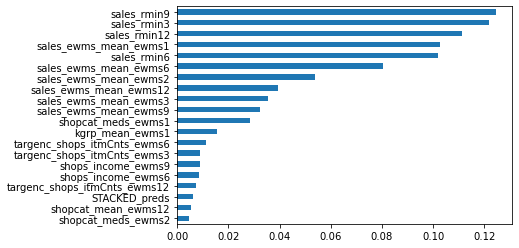

In [234]:
res = plot_feature_importances(fitted, top_n=20)

In [67]:
import xgboost as xgb

class xgb_model:
    def __init__(self, num_boost_round, **params):
        self.params = {
            'max_depth':6,
            'min_child_weight': 1,
            'eta':.3,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'lambda':1,
            'gamma':0.1,
            'objective':'reg:squarederror',
            # leave nthread default - detects all cores automatically
        }
        self.params.update(params)
        self.fitted_model = None
        self.num_boost_round = num_boost_round
       
    def fit(self, X, Y):
        dm_train = xgb.DMatrix(X,Y)
        self.fitted_model = xgb.train(self.params, dtrain=dm_train, num_boost_round=self.num_boost_round)
        return self
    
    def predict(self, X):
        assert self.fitted_model is not None, 'Must fit first'
        dm = xgb.DMatrix(X)
        return self.fitted_model.predict(dm)
    
    @property
    def feature_importances_(self):
        return pd.Series(self.fitted_model.get_score(importance_type='weight'))

## Rolling Cross Validation

In [68]:
class results:
    def __init__(self, model, fitted_models, preSub_is_scores, preSub_oos_scores, is_scores, os_scores, times=None):
        self.model = model
        self.fitted_models = fitted_models
        self.preSub_is_scores = preSub_is_scores
        self.preSub_oos_scores = preSub_oos_scores
        self.is_scores = is_scores
        self.os_scores = os_scores
        self.times = times
        
    @property
    def keys(self):
        return sorted(self.fitted_models.keys())
        
    @property
    def scores(self):
        return pd.concat([pd.Series(self.preSub_is_scores, name='PreInSampleRMSE'), pd.Series(self.is_scores, name='inSampleRMSE'), pd.Series(self.preSub_oos_scores, name='PreOutSampleRMSE'), pd.Series(self.os_scores, name='outSampleRMSE')], axis=1)
        

In [69]:
def rolling_cross_validation(model, data_months_list, post_process_preds = None, num_lagged_values=12, validate_months_num=None, num_stack_months=1, pred_fill_value=0, fit_final=False, drop_cols=None):
    if post_process_preds is None:
        post_process_preds = lambda x: x
        
    Xs_deque = deque()
    Ys_deque = deque()
    Ysubs_deque = deque()
    
    for month in data_months_list[:num_stack_months]:
        X_, Y_, Ysub_= get_single_month_XY(month, drop_cols=drop_cols, num_lagged_values=num_lagged_values)
        Xs_deque.append(X_)
        Ys_deque.append(Y_)
        Ysubs_deque.append(Ysub_)
        
           
    max_validate_months = len(data_months_list) - num_stack_months - 1
    if validate_months_num is None:
        validate_months_num = max_validate_months
    else:
        validate_months_num = min(validate_months_num, max_validate_months)
        
    
    fitted_models = {}
    in_sample_scores = {}
    oos_scores = {}
    prepred_is_scores = {}
    prepred_os_scores = {}
    loop_times = []
    
    
    for month in data_months_list[num_stack_months: num_stack_months + validate_months_num]:
        print(f'Working on: {month}')
        loop_start = time.time()
        
        X_train = pd.concat(Xs_deque)
        Y_train = pd.concat(Ys_deque)
        Y_sub_train = pd.concat(Ysubs_deque)
        
        X_val, Y_val, Y_sub_val = get_single_month_XY(month, drop_cols=drop_cols, num_lagged_values=num_lagged_values)
        fitted, ytrain_pred, yval_pred, elapsed_time = fit_and_predict(model, X_train, Y_train, X_val)
        fitted_models[month] = fitted
        print(f'fit time: {elapsed_time}')
        
        prepred_is_scores[month] = np.sqrt(mean_squared_error(Y_train, ytrain_pred))
        prepred_os_scores[month] = np.sqrt(mean_squared_error(Y_val, yval_pred))
        
        ytrain_pred = conform_to_subY(X_train, ytrain_pred, Y_sub_train, fill_value=pred_fill_value)
        yval_pred = conform_to_subY(X_val, yval_pred, Y_sub_val, fill_value=pred_fill_value)
        
        ytrain_pred = post_process_preds(ytrain_pred)
        yval_pred = post_process_preds(yval_pred)
        
        in_sample_scores[month] = np.sqrt(mean_squared_error(Y_sub_train, ytrain_pred))
        oos_scores[month] = np.sqrt(mean_squared_error(Y_sub_val, yval_pred))
        
        Xs_deque.popleft()
        Ys_deque.popleft()
        Ysubs_deque.popleft()
        
        Xs_deque.append(X_val)
        Ys_deque.append(Y_val)
        Ysubs_deque.append(Y_sub_val)

        
        loop_end = time.time()
        loop_times.append(loop_end - loop_start)
        
    
    if fit_final:
        X_train = pd.concat(Xs_deque)
        Y_train = pd.concat(Ys_deque)
        Y_sub_train = pd.concat(Ysubs_deque)
        
        fitted, ytrain_pred, yval_pred, elapsed_time = fit_and_predict(model, X_train, Y_train, X_val)
        fitted_models['FINAL'] = fitted
        prepred_is_scores['FINAL'] = np.sqrt(mean_squared_error(Y_train, ytrain_pred))
        ytrain_pred = conform_to_subY(X_train, ytrain_pred, Y_sub_train, fill_value=pred_fill_value)
        ytrain_pred = post_process_preds(ytrain_pred)
        in_sample_scores['FINAL'] = np.sqrt(mean_squared_error(Y_sub_train, ytrain_pred))
    
    return results(model, fitted_models, prepred_is_scores, prepred_os_scores, in_sample_scores, oos_scores, loop_times)

### XGB

Tune num trees - v1

In [100]:
mod = xgb_model(num_boost_round=5, max_depth=5, eta=0.3, gpu_id=0, tree_method='gpu_hist')
xgb1 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb1.scores

Working on: 2015-09
fit time: 448.7321078777313


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,2.071636,2.577353,3.51808,4.621091


In [107]:
mod = xgb_model(num_boost_round=10, max_depth=5, eta=0.3, gpu_id=0, tree_method='gpu_hist')
xgb2 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb2.scores

Working on: 2015-09
fit time: 453.72365856170654


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.878408,2.336968,3.40445,4.488744


In [109]:
mod = xgb_model(num_boost_round=20, max_depth=5, eta=0.3, gpu_id=0, tree_method='gpu_hist')
xgb3 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb3.scores

Working on: 2015-09
fit time: 443.2325327396393


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.71654,2.135615,3.504612,4.598303


This is a decrease in OutSample performance

Tune max_depth

In [110]:
mod = xgb_model(num_boost_round=10, max_depth=10, eta=0.3, gpu_id=0, tree_method='gpu_hist')
xgb4 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb4.scores

Working on: 2015-09
fit time: 451.9696443080902


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.537542,1.903766,3.454867,4.465643


In [111]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist')
xgb5 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb5.scores

Working on: 2015-09
fit time: 467.3969130516052


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.452223,1.778487,3.374519,4.414141


In [112]:
mod = xgb_model(num_boost_round=10, max_depth=20, eta=0.3, gpu_id=0, tree_method='gpu_hist')
xgb6 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb6.scores

Working on: 2015-09
fit time: 471.0745520591736


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.399112,1.702981,3.375141,4.392479


In [113]:
mod = xgb_model(num_boost_round=10, max_depth=25, eta=0.3, gpu_id=0, tree_method='gpu_hist')
xgb7 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb7.scores

Working on: 2015-09
fit time: 597.5037202835083


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.374042,1.674943,3.443991,4.545496


Tune min_child_weight

In [69]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3)
xgb8 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb8.scores

Working on: 2015-09
fit time: 415.39419531822205


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.555581,1.905125,3.256072,4.314246


In [71]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=4)
xgb9 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb9.scores

Working on: 2015-09
fit time: 409.84160470962524


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.616427,1.981819,3.301576,4.252826


In [69]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=2)
xgb10 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb10.scores

Working on: 2015-09
fit time: 380.04951190948486


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.49811,1.832468,3.347331,4.310683


Tune gamma - v1

In [70]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1)
xgb11 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb11.scores

Working on: 2015-09
fit time: 401.9728960990906


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.558374,1.910212,3.224336,4.20106


In [71]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.2)
xgb12 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb12.scores

Working on: 2015-09
fit time: 381.93823504447937


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.563509,1.913821,3.408209,4.520965


Tune colsample_bytree

In [72]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1, colsample_bytree=0.5)
xgb13 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb13.scores

Working on: 2015-09
fit time: 367.2258598804474


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.554905,1.905897,3.523711,4.475282


In [73]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1, colsample_bytree=0.25)
xgb14 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb14.scores

Working on: 2015-09
fit time: 395.63709235191345


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.570256,1.922398,3.715294,4.627332


In [74]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1, colsample_bytree=0.75)
xgb15 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb15.scores

Working on: 2015-09
fit time: 389.1943893432617


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.587069,1.946151,3.416441,4.504229


In [75]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1, colsample_bytree=0.9)
xgb16 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb16.scores

Working on: 2015-09
fit time: 425.58503127098083


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.54764,1.889438,3.576048,4.724562


In [76]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1, colsample_bytree=0.95)
xgb17 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb17.scores

Working on: 2015-09
fit time: 405.35559368133545


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.560242,1.910468,3.56527,4.611157


In [78]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1, colsample_bytree=1)
xgb18 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb18.scores

Working on: 2015-09
fit time: 400.2204647064209


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.581847,1.937094,3.624732,4.79397


In [79]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1, colsample_bytree=0.8)
xgb19 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb19.scores

Working on: 2015-09
fit time: 489.6808226108551


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.577413,1.933916,3.57007,4.713628


repeat lowest - preOutSample was 3.224336

In [80]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1)
xgb20 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb20.scores

Working on: 2015-09
fit time: 398.8595907688141


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.570103,1.922401,3.49114,4.616975


Same parms, different results: 3.224336, 3.49114  - big spread in random difference

In [81]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1, colsample_bytree=0.70)
xgb21 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb21.scores

Working on: 2015-09
fit time: 404.32211780548096


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.560746,1.912095,3.490181,4.522107


Re-tune num trees

In [82]:
mod = xgb_model(num_boost_round=15, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1, colsample_bytree=0.70)
xgb22 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb22.scores

Working on: 2015-09
fit time: 433.95582008361816


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.467228,1.793479,3.558914,4.442888


In [83]:
mod = xgb_model(num_boost_round=7, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3, gamma=0.1, colsample_bytree=0.70)
xgb23 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb23.scores

Working on: 2015-09
fit time: 394.7556836605072


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.690958,2.081592,3.543582,4.599802


Tune subsample

In [67]:
mod = xgb_model(num_boost_round=15, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.5)
xgb24 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb24.scores

Working on: 2015-09
fit time: 417.0325565338135


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.600846,1.959484,3.533276,4.664327


In [68]:
mod = xgb_model(num_boost_round=15, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.25)
xgb24 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb24.scores

Working on: 2015-09
fit time: 383.82120156288147


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.939659,2.373006,3.78051,4.943948


In [69]:
mod = xgb_model(num_boost_round=15, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.75)
xgb25 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb25.scores

Working on: 2015-09
fit time: 378.18624448776245


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.484346,1.812144,3.389474,4.395206


In [70]:
mod = xgb_model(num_boost_round=15, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85)
xgb26 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb26.scores

Working on: 2015-09
fit time: 459.5859055519104


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.452081,1.777478,3.332366,4.38954


reg alpha

In [71]:
mod = xgb_model(num_boost_round=15, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1e-2)
xgb27 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb27.scores

Working on: 2015-09
fit time: 391.82743763923645


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.466667,1.794442,3.453205,4.512323


In [72]:
mod = xgb_model(num_boost_round=15, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=0.1)
xgb28 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb28.scores

Working on: 2015-09
fit time: 396.5325367450714


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.4524,1.776852,3.320794,4.301734


In [73]:
mod = xgb_model(num_boost_round=15, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgb29 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb29.scores

Working on: 2015-09
fit time: 401.88452410697937


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.460326,1.788103,3.288492,4.296378


In [74]:
mod = xgb_model(num_boost_round=15, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=10)
xgb30 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb30.scores

Working on: 2015-09
fit time: 395.5733845233917


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.45779,1.784869,3.350702,4.380897


In [75]:
mod = xgb_model(num_boost_round=15, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=0.5)
xgb31 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb31.scores

Working on: 2015-09
fit time: 392.5182545185089


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.466542,1.79486,3.444049,4.5182


In [76]:
mod = xgb_model(num_boost_round=15, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=2)
xgb32 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb32.scores

Working on: 2015-09
fit time: 393.9164659976959


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.460489,1.789084,3.412619,4.480037


keep reg alpha at 1

In [77]:
mod = xgb_model(num_boost_round=45, max_depth=15, eta=0.1, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgb33 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb33.scores

Working on: 2015-09
fit time: 416.79675006866455


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.462329,1.790995,3.373817,4.364335


In [78]:
mod = xgb_model(num_boost_round=100, max_depth=15, eta=0.05, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgb34 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb34.scores

Working on: 2015-09
fit time: 479.00764989852905


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.438745,1.762985,3.392436,4.385812


In [79]:
mod = xgb_model(num_boost_round=150, max_depth=15, eta=0.05, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgb35 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb35.scores

Working on: 2015-09
fit time: 480.32368564605713


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.393894,1.706193,3.352824,4.311378


In [80]:
mod = xgb_model(num_boost_round=300, max_depth=15, eta=0.025, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgb36 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb36.scores

Working on: 2015-09
fit time: 578.7205331325531


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.393748,1.705426,3.317894,4.312685


In [81]:
mod = xgb_model(num_boost_round=400, max_depth=15, eta=0.025, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgb37 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb37.scores

Working on: 2015-09
fit time: 654.8986668586731


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.373772,1.679657,3.390463,4.385338


In [83]:
mod = xgb_model(num_boost_round=800, max_depth=15, eta=0.01, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgb38 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb38.scores

Working on: 2015-09
fit time: 930.6585764884949


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.387192,1.697351,3.406284,4.393435


In [84]:
mod = xgb_model(num_boost_round=1000, max_depth=15, eta=0.01, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgb39 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb39.scores

Working on: 2015-09
fit time: 1071.7277617454529


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.372758,1.678388,3.411441,4.405141


In [85]:
mod = xgb_model(num_boost_round=1000, max_depth=20, eta=0.01, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgb40 = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=False)
xgb40.scores

Working on: 2015-09
fit time: 2256.491931438446


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.329592,1.618455,3.44159,4.423015


Stack more months

In [86]:
mod = xgb_model(num_boost_round=300, max_depth=15, eta=0.025, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgb41 = rolling_cross_validation(mod, months[16:], num_lagged_values=0, num_stack_months=16, fit_final=False)
xgb41.scores

Working on: 2015-09
fit time: 770.0432236194611


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.302002,1.566265,3.324735,4.341179


# Final Model

In [70]:
mod = xgb_model(num_boost_round=300, max_depth=15, eta=0.025, gpu_id=0, tree_method='gpu_hist', min_child_weight=3,
                gamma=0.1, colsample_bytree=0.70, subsample=0.85, reg_alpha=1)
xgbFinal = rolling_cross_validation(mod, months[19:], num_lagged_values=0, num_stack_months=13, fit_final=True)
xgbFinal.scores

Working on: 2015-09
fit time: 573.8778414726257


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-09,1.390869,1.701459,3.346659,4.301463
FINAL,1.368414,1.691437,NaN,NaN


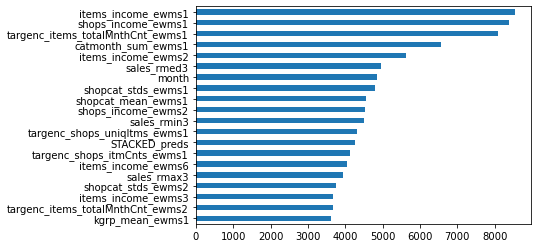

In [83]:
res = plot_feature_importances(xgbFinal.fitted_models['FINAL'], top_n=20)
plt.savefig('Top20.png', bbox_inches='tight')

# Preparing Submission

In [71]:
def merge_pred_with_test(prediction, fill_val=0, pred_col='item_cnt_month'):
    assert pred_col in prediction.columns, f'Couldnt find {pred_col}'
    data_fol = 'data'
    test = pd.read_csv(os.path.join(data_fol, 'test.csv'))
    merged =  pd.merge(test, prediction, on=['shop_id', 'item_id'], how='left').fillna(fill_val)
    if pred_col != 'item_cnt_month':
        merged = merged.rename(columns={pred_col:'item_cnt_month'})
    return merged.set_index('ID')['item_cnt_month']

In [72]:
Xt, Yt, _ = get_single_month_XY(months[-1])

In [73]:
y_pred = pd.DataFrame({'item_cnt_month':xgbFinal.fitted_models['FINAL'].predict(Xt)}, index=Xt.index)
y_sub = merge_pred_with_test(y_pred)

In [74]:
y_sub.to_csv('xgbFinal.csv')

In [77]:
np.clip(0, 15, y_sub).to_csv('xgbFinal_clipped15.csv')

# Storing model

In [89]:
import pickle

In [90]:
model = xgbFinal.fitted_models['FINAL'].fitted_model

In [91]:
pickle.dump(model, open("final_xgboost_model.p", "wb"))